In [53]:
#image analysis
import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
from scipy import optimize
import glob
from alienlab.regression_func import *
import copy
from VoltageIntensityClass import VoltageIntensity
from tqdm import tqdm

from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from skimage.transform import resize

import mvgavg

import scipy

import tifffile as tiff

#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename, askdirectory

from VoltageIntensityClass import VoltageIntensity


import time
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets
from alienlab.regression_func import platt, residuals
from alienlab.utils import clip
from alienlab.segment import uniform_mask, label_to_data
from alienlab.widget import click_to_graph
#%matplotlib inline


from mvgavg import mvgavg





In [57]:
#file_path = "ENTER NAME OF THE FILE YOU DROPPED IN THE FILE SECTION HERE" 
file_folder = askdirectory(title = 'Select an experiment folder', initialdir="G:/DREAM/from_github/PAMFluo/Experiments")  # pops up a window to select your file 
# uncomment this line if you use this jupyter notebook locally
#'G:/DREAM/from_github/PAMFluo/Experiments/2021-06-24_12_12_Ek_video'
file_folder

'G:/DREAM/from_github/PAMFluo/Experiments/2021-10-29_15_27_qE_calib'

In [58]:
show = True #option to output intermediary images in the segmentation process

# Import video file in HQ and select ROI
file_path = file_folder + "/video.tiff"
direc = os.path.split(file_path)[0]

# Initialize plotting tools
g = alienlab.plot.ShowFigure()
g.figsize = (15,7)
g.save_folder = "images"
g.date = False
p = alienlab.plot.PlotFigure()
p.figsize = (15,7)
p.save_folder = "images"
p.date = False

In [59]:
# read the stacked frame. dim = NxHxW (N images in the video, Heigt, Width)

frames_full = skimage.io.imread(file_path)

#frames_full = np.stack([frames_full[:,:,1]]*10, 0) 
#uncomment this line if you have a single RGB image. The [:,:,1] stands for selection of the green channel

FO = FramesOperator(frames_full)
im = normalize(FO.frames[0], 0, 1)
im = grey_to_rgb(im)*255

# CROP
#y, x = alienlab.io.select_roi(np.uint8(im)) #select area of interest

#FO.x = x
#FO.y = y
#FO.crop() #crop image

start_time = time.time()
FO.compute_stats() #compute various statistical values on the frames and the pixels
FO.normalize(0, 1)
print("--- Computed frames statistics in %04f seconds ---" % (time.time() - start_time))

#FO.global_stats: each array has size N, number of frames and represents the stats of each frame
#FO.frames_stats: each array has size FO.x, FO.y and is an image representing the N frames stats overlayed

if show:
    p.title = 'statistics'
    p.xlabel = 'frame number'
    p.ylabel = 'amplitude'
    p.label_list = ['max', 'min', 'mean', 'std']
    fig = p.plotting(np.asarray(FO.inds), [FO.global_stats['mean'], 
                        FO.global_stats['min'], 
                        FO.global_stats['mean']])
    p.save_name = 'frames_stats'
    p.saving(fig)

''' IMAGE SEGMENTATION '''

# selection of the frames with high dynamics that will be used for the image segmentation process.
# Let M be the highest value taken by a pixel in all the frames of the video. The frame F is kept for processing only if at
# least one pixel in the frame F has a value above 0.8*M. 
FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.8)


--- Computed frames statistics in 1.490749 seconds ---


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [61]:

plt.figure(figsize = (5, 3))
FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.8) # Select only images with high intensity to increase contrast and lower computation time
imref = FO.frames[FO.selected_inds].sum(axis = 0)
plt.imshow(imref)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [62]:
def segment_image(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, interact = True, showit = show):
    
    start_time = time.time()
    FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.98) # Select only images with high intensity to increase contrast and lower computation time

    #apply contrast filter to all frames
    frames_contrast = FO.apply(skimage.filters.rank.enhance_contrast,  selem = skimage.morphology.disk(contrast))
    #apply autolevel filter to all frames
    frames_autolevel = FO.apply(skimage.filters.rank.autolevel, selem = skimage.morphology.disk(autolevel))
    #sum the contrast images to get a reference grey-level contrast image
    frame_contrast = np.sum(frames_contrast, axis = 0)
    #sum the autolevel images to get a reference grey-level autolevel image
    frame_autolevel = np.sum(frames_autolevel, axis = 0)
    #obtain contrast mask from reference contrast image
    mask_contrast = make_binary(frame_contrast, soft_hard = 0.4)
    #otbain autolevel mask from reference autolevel image
    mask_autolevel =  make_binary(frame_autolevel, soft_hard = 0.8)
    #intersection of contrast aud autolevel masks
    mask_intersect = mask_contrast * mask_autolevel
    #clean the masks with a binary opening
    mask_intersect = skimage.morphology.binary_opening(mask_intersect, selem = skimage.morphology.disk(disk_size))
    #reference image of altitude for the watershed
    auto_contrast = normalize(mask_intersect * frame_autolevel)
    print("--- Computed binary mask in %04f seconds ---" % (time.time() - start_time))

    g.cmap = "inferno"
    if showit:
        g.figsize = (40,15)
        g.title_list =  'contrast', 'contrast threshold', 'mask intersect','autolevel', 'autolevel threshold','segmentation image'
        g.col_num = 3
        fig = g.multi([frame_contrast, mask_contrast, mask_intersect, 
                       frame_autolevel, mask_autolevel,  auto_contrast])
        g.save_name = 'Segmentation reference'
        g.saving(fig)

    start_time = time.time()
    ref = auto_contrast
    mask = mask_intersect
    #locate the local maxima
    local_maxi = alienlab.segment.local_maxima(auto_contrast, max_contrast, g,
                                                     ref_distance = dist_max, mask = mask, show = showit)
    #perform watershed segmentation
    watershed_im_mask = alienlab.segment.watershed(ref, mask, local_maxi,
                                                         g, ref_distance = dist_seg, show = False)
    segmented = watershed_im_mask
    print("--- Computed segmentation in %04f seconds ---" % (time.time() - start_time))

    if showit:
        alienlab.segment.show_segmentation(FO, segmented, g)
        
    if interact == False:
        return watershed_im_mask, FO
    
mask, FO = segment_image(contrast = 2, autolevel = 6, dist_max = True, dist_seg=True, disk_size = 2, max_contrast = 4, interact = False, showit= True)

g.cmap = "tab20"
g.figsize = (10,5)
fig = g.multi(mask)

L, H  = np.shape(mask)

items_dict = label_to_data(mask, FO)

--- Computed binary mask in 2.555999 seconds ---


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

g:\dream\from_github\alienlab\alienlab\segment.py:38: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = skimage.feature.peak_local_max(im, indices = False, min_distance=min_distance)
g:\dream\from_github\alienlab\alienlab\segment.py:41: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  dist_local_maxi = skimage.feature.peak_local_max(distance, indices = False, min_distance=min_distance)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

--- Computed segmentation in 0.644634 seconds ---


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

100%|███████████████████████████████████████████████████████████████████████████████| 419/419 [00:01<00:00, 320.80it/s]


In [63]:
data_sequence = {}
video_sequence = {}
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

file_path = glob.glob(file_folder + "/*_output_plot.csv")[0] # pops up a window to select your file
data_sequence = pd.read_csv(file_path)

time_array = np.array(data_sequence["time (s) intensity"])
fluo  = np.array(data_sequence["voltage (V) fluorescence"])
amplitude = np.array(data_sequence["voltage (V) intensity"])

axs[0].plot(time_array, fluo)
axs[0].set_title("MPPC high, voltage")

start = 0
axs[1].plot(mvgavg(time_array, 100)[start:], (mvgavg(fluo, 100))[start:])
axs[1].set_title("MPPC high, voltage")


file_path = file_folder + "/video.tiff"
video = tiff.imread(file_path)
video_sequence[0]=video
v_high = np.mean(video, axis = (1,2))
file_path = file_folder + "/video_timing.npy"
v_time_high = np.load(file_path)
t0 = v_time_high[0]
v_time_high = v_time_high -t0
v_time_high = v_time_high%(3600*24)


file_path = file_folder + "/video.tiff"
video_file_high = tiff.imread(file_path)


plt.figure()
plt.plot(v_high)



zone = []
time_zone = []
video_zone = []

indices_clean = 0, 10, 112, 542, len(v_high)        
THRESHOLD = 0.6
N_mvg = 5


for i in range(len(indices_clean)-1):
        ind_range = list(range(indices_clean[i],indices_clean[i+1]))
        trace = v_high[ind_range]
        ind = trace > THRESHOLD
        nind = trace <= THRESHOLD
        zone.append(trace[ind])
        zone.append(mvgavg(trace[nind], N_mvg))
        
        v_time = v_time_high[ind_range]
        time_zone.append(v_time[ind])
        time_zone.append(mvgavg(v_time[nind], N_mvg))
        
        vid = video_file_high[ind_range]
        video_zone.append(vid[ind])
        video_zone.append(mvgavg(vid[nind], N_mvg))

   
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

time_zone[2] = np.append(time_zone[3][0], time_zone[2])
zone[2] = np.append(zone[0][0], zone[2])
video_zone[2] = np.concatenate([video_zone[0], video_zone[2]])


for k in range(len(zone)):
        print(k)
        axs[k%2].plot(time_zone[k], zone[k], label = k)
        axs[k%2].set_title("zone %d"%k)
        axs[k%2].legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IndexError: index 122 is out of bounds for axis 0 with size 122

In [ ]:
plt.figure()
plt.plot(time_array, amplitude/amplitude.max())
plt.plot(v_time_high, v_high/v_high.max())

In [ ]:
p.yval = zone[1::2]
p.xval = time_zone[1::2]
p.label_list = ["0", "1", "2", "3", "4"]
p.plotting(p.xval, p.yval)


In [273]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#x0, x1, y0, y1 = 100, 500, 300, 700
#x0, x1, y0, y1 = 10, 800, 30, 1000
axs[0].imshow(np.mean(video_sequence[0], axis = 0), cmap = "gray")#[2, x0:x1, y0:y1], vmin = 0, vmax = 30)

plt.figure(figsize = (10, 5))
plt.plot(v_time_high, np.mean(video_sequence[0][:, 100:500, 300:700], axis = (1,2)))
plt.xlabel("time (s)")
plt.ylabel("fluorescence intensity")

<ipython-input-273-e2c0c8af131a>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3, figsize=(12, 4))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'fluorescence intensity')

In [274]:

video_high = []

file_path = file_folder + "/video.tiff"
video_file_high = tiff.imread(file_path)


algae_list = list(items_dict.keys())
for P in [5]:#[len(algae_list)]:#[8, 10, 12, 15, 18, 20, 25, 30, 35, 40, 60, 90, 120, 180, 200, 250, 300, 400, 500, 600, 700]:

    #for algae in random.sample(algae_list, P):
    for algae in tqdm(algae_list):
        #if int(algae):# in ['1', '80', '400', '250']:
            i = 0


            x_coords =  items_dict[algae]['x_coords']
            y_coords =  items_dict[algae]['y_coords']
            
            trace = np.mean(video_file_high[:, x_coords, y_coords], axis = (1))
            video_high.append(np.array(trace))

video_high = np.array(video_high)


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 144.37it/s]


In [275]:
def get_fit(decay, time, give_y = False):    

    time_spread = time.max()-time.min()
    start = np.mean(decay[0])
    stop = np.mean(decay[-10:])
    x0 = [start, time_spread, stop]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e8,1e8),
                                args = (time, decay, exp_decay))
    
    if give_y:
        return np.array(parameters_estimated.x), exp_decay(parameters_estimated.x, time)
    else:
        return np.array(parameters_estimated.x)

def make_fit(decay, time_array):
    plt.figure()
    params, ypred = get_fit(decay, time_array, give_y = True)
    plt.plot(time_array, ypred, label = params[1])
    plt.plot(time_array, decay, '.')
    plt.xlabel("time(s)")
    plt.ylabel("fluorescence")
    plt.legend()
    

flat_mask = mask.flatten()


L = len(video_zone) + 1
col = 3
fig, axs = plt.subplots(col, L//col, figsize=(15,15))

video_list_init = video_zone[2:]
time_list = time_zone[2:]
video_list = []
for video in video_list_init:
    if video.shape[0]!=0:
        video_list.append(video)

for i, video in enumerate(video_list): 
    video_list[i] = video.reshape(video.shape[0], -1)



for ind in [3, 9, 12]:
    if ind != 0:
        pos = flat_mask == ind
        for i, video in enumerate(video_list):
            y = np.mean(video[:, pos], axis = 1)    
            x = time_list[i]
            params, ypred = get_fit(y, x, give_y = True)
            axs[(i+1)%col][(i+1)//col].plot(x, ypred, label = params[1])
            axs[(i+1)%col][(i+1)//col].plot(x, y, '.')
            axs[(i+1)%col][(i+1)//col].legend()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

g:\dream\from_github\alienlab\alienlab\regression_func.py:70: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
g:\dream\from_github\alienlab\alienlab\regression_func.py:70: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0


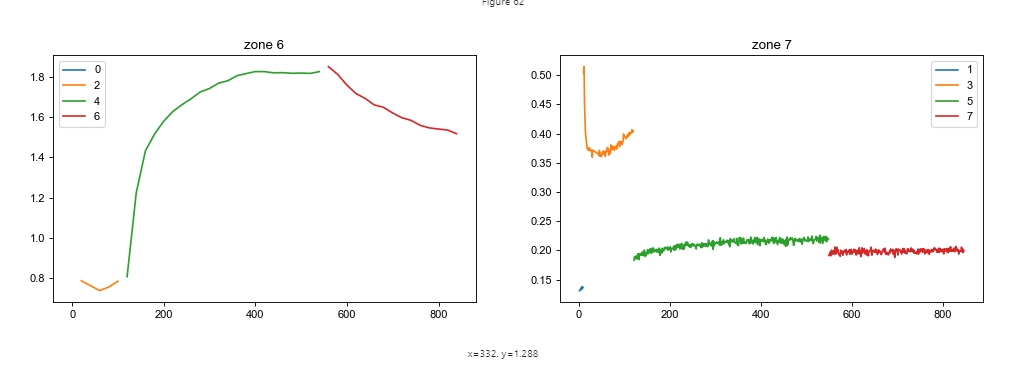

In [276]:
params_tot = []
im_tau = []
for z in range(2,8):
    if z%2==0:
        fig, axs = plt.subplots(1, 3, figsize = (18, 4))

    S = video_zone[z].shape[0]
    params_high = Parallel(n_jobs = -1 )(delayed(get_fit)(np.mean(video_zone[z].reshape(S, -1)[:,flat_mask==i], axis = 1), time_zone[z]) for i in range(len(algae_list)))
    params_tot.append(np.array(params_high))
    im_tau_high = np.zeros(mask.shape)
    for i in range(len(params_high)):
        im_tau_high[mask==i]=params_high[i][1]

    im_tau.append(im_tau_high)

    params_high = np.array(params_high)
    tau_high = params_high[:,1]
    if z not in [7]:
        axs[0].imshow(np.log(im_tau_high))
        clipped = clip(tau_high, high = 85, low = 2)
        if z%2==0:
            axs[1].hist(clipped, color = (1,0,0,0.5))
        else:
            axs[1].hist(clipped, color = (0,0,1,0.5))

            axs[2].scatter(params_tot[z-3][:,1], params_tot[z-2][:,1])
            axs[2].set_xlabel("time(s) pulses")
            axs[2].set_ylabel("time(s) FD")
            axs[2].set_xlim(clipped.min(), clipped.max())
            axs[2].set_ylim(clipped.min(), clipped.max())
            
np.save(file_folder + "/im_ref.npy", imref)
np.save(file_folder + "/im_tau_high.npy", im_tau_high)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-276-a3c8ee4797c5>:19: RuntimeWarning: invalid value encountered in log
  axs[0].imshow(np.log(im_tau_high))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [277]:
import importlib

importlib.reload(alienlab.widget)
from alienlab.widget import click_to_graph

file_path = file_folder + "/video.tiff"
video_file_high = tiff.imread(file_path)

video_list =  video_zone[2:]
time_list =  time_zone[2:]
initial_condition_list = [[],[],[],[],[],[],[],[]]
click_to_graph(mask, np.log(im_tau[2]),video_list,time_list, get_fit, clipit=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Textarea(value='', description='event:', placeholder='')

# Compare

In [ ]:
mdirectory = askdirectory()


In [ ]:
list_directory = glob.glob(mdirectory + "/*")
plt.figure()
list_val =  [10, 30, 50, 100, 150, 200, 250, 300, 350, 400,10, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450]
for i in range(len(list_directory)):
    file_folder = list_directory[i]
    file_path = glob.glob(file_folder + "/*_qE_decay.csv")[0] # pops up a window to select your file
    data = pd.read_csv(file_path)
    time_array = np.array(data["time (s) q"])
    time_high = time_array[:-10]
    fluo_high  = np.array(data["voltage (V) q"])
    fluo_high = fluo_high[:-10]
    npq_high =  (fluo_high.max()-fluo_high)/fluo_high
    plt.plot(time_high, npq_high, label = list_val[i])
    file_path = glob.glob(file_folder + "/*SP_before_after.csv")[0] # pops up a window to select your file
    data = np.genfromtxt(file_path)
    fm = data[0][0]- data[0][1]
    fmp = data[1][0]-data[1][1]
    #plt.plot(list_val[i], (fm-fmp)/fmp, 'o')
plt.legend()
plt.show()

In [ ]:
data[0]

In [ ]:
list_directory = glob.glob(mdirectory + "/*")

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

minute = 60
lengths_pulse = [300, 150, 50]
periods_pulse = [0.1*minute, 0.5*minute, 1*minute]
move_plate = True

n = 3
means  = {}
stds = {}
means['high'] = np.zeros((n,n))
stds['high'] =  np.zeros((n,n))
means['pulses'] =  np.zeros((n,n))
stds['pulses'] =  np.zeros((n,n))

i = 0
for k, length in enumerate(lengths_pulse): 
    for l, period in enumerate(periods_pulse):
        file_folder = list_directory[i]
        file_path = glob.glob(file_folder + "/*_ojip_curve.csv")[0] # pops up a window to select your file
        data = pd.read_csv(file_path)
        time_array = np.array(data["time (s) o"])
        time_high = time_array[:-10]
        fluo_high  = np.array(data["voltage (V) o"])
        fluo_high = fluo_high[:-10]
        npq_high =  (fluo_high.max()-fluo_high)/fluo_high

        file_path = glob.glob(file_folder + "/measure_pulse.csv")[0] # pops up a window to select your file
        data= pd.read_csv(file_path)
        fluo_pulses  = np.array(data)
        file_path = glob.glob(file_folder + "/time_pulse.csv")[0] # pops up a window to select your file
        data = pd.read_csv(file_path)
        time_pulses  = np.array(data)
        npq_pulses = (fluo_pulses.max()-fluo_pulses)/fluo_pulses

        axs[0][0].plot(time_high, fluo_high)
        axs[0][0].set_title("MPPC high, voltage")

        axs[0][1].plot(time_pulses, fluo_pulses, '.')
        axs[0][1].set_title("MPPC pulses, voltage")


        im_tau_high = np.load(file_folder + "/im_tau_high.npy")
        im_tau_pulses = np.load(file_folder + "/im_tau_pulses.npy")
        axs[1][0].hist(clip(im_tau_high.flatten(), high = 99, low = 1), range = (0, 30), bins = 25, label = "L: %d ms, dt: %d s"%(length, period))
        axs[1][1].hist(clip(im_tau_pulses.flatten(), high = 99, low = 1), range = (0,180), bins = 25, label =  "L: %d ms, dt: %d s"%(length, period))
        
        high = 97
        low = 3
        means['high'][k][l] = np.mean(clip(im_tau_high, high = high, low = low))
        stds['high'][k][l] = np.std(clip(im_tau_high, high = high, low = low))
        means['pulses'][k][l] = np.mean(clip(im_tau_pulses, high = high, low = low))
        stds['pulses'][k][l] = np.std(clip(im_tau_pulses, high = high, low = low))
        
        plt.legend()
        i += 1

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))

axs[0][0].imshow(means["pulses"])
axs[0][0].set_title("mean pulses")

axs[1][0].imshow(means["high"])
axs[1][0].set_title("mean high")

axs[0][1].imshow(stds["pulses"])
axs[0][1].set_title("std pulses")

axs[1][1].imshow(stds["high"])
axs[1][1].set_title("std high")

In [ ]:
list_directory = glob.glob(mdirectory + "/*")


minute = 60
lengths_pulse = [300, 150, 50]
periods_pulse = [0.1*minute, 0.5*minute, 1*minute]

D = len(list_directory)//3

fig, axs = plt.subplots(D, 3, figsize=(10, 2*D))

i = 0
for k, length in enumerate(lengths_pulse): 
    for l, period in enumerate(periods_pulse):
        file_folder = list_directory[i]


        im_tau_high = np.load(file_folder + "/im_tau_high.npy")
        axs[i%D][i//D].imshow(im_tau_high, vmin =0 , vmax = 20)
        axs[i%D][i//D].axis("off")
        i += 1
        
    
D = len(list_directory)//3

fig, axs = plt.subplots(D, 3, figsize=(10, 2*D))

i = 0
for k, length in enumerate(lengths_pulse): 
    for l, period in enumerate(periods_pulse):
        file_folder = list_directory[i]


        im_tau_pulses = np.load(file_folder + "/im_tau_pulses.npy")
        axs[i%D][i//D].imshow(im_tau_pulses, vmin =0 , vmax = 130)
        axs[i%D][i//D].axis("off")
        i += 1

In [ ]:
i//2

